In [32]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [33]:
adata = sc.read_visium('/Users/maiia.shulman/Downloads/vitatrack/Spatial Multimodal Analysis of Transcriptomes and Metabolomes in Tissues/sma/V11L12-038/V11L12-038_A1/output_data/V11L12-038_A1_RNA/outs')

/Users/maiia.shulman/anaconda3/envs/vitatrack/lib/python3.9/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/maiia.shulman/anaconda3/envs/vitatrack/lib/python3.9/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [34]:
adata.var_names_make_unique()

In [35]:
adata.var["mt"] = adata.var_names.str.startswith("MT-")

In [36]:
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

In [37]:
adata

AnnData object with n_obs × n_vars = 2856 × 32285
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatial'
    obsm: 'spatial'

## QC and preprocessing

We perform some basic filtering of spots based on total counts and expressed genes

<Axes: xlabel='n_genes_by_counts', ylabel='Count'>

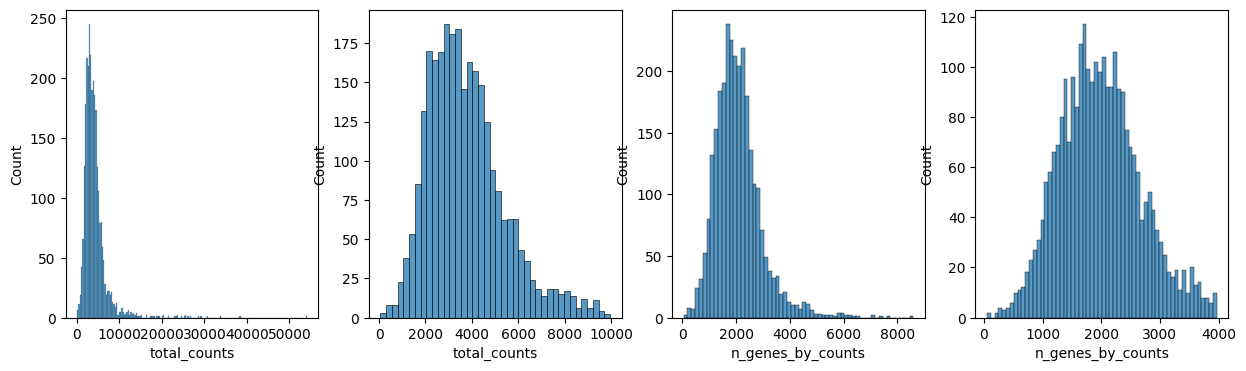

In [38]:
fig, axs = plt.subplots(1, 4, figsize=(15, 4))
sns.histplot(adata.obs["total_counts"], kde=False, ax=axs[0])
sns.histplot(
    adata.obs["total_counts"][adata.obs["total_counts"] < 10000],
    kde=False,
    bins=40,
    ax=axs[1],
)
sns.histplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
sns.histplot(
    adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 4000],
    kde=False,
    bins=60,
    ax=axs[3],
)

In [39]:
sc.pp.filter_cells(adata, min_counts=1000)
sc.pp.filter_cells(adata, max_counts=35000)
adata = adata[adata.obs["pct_counts_mt"] < 20].copy()
print(f"#cells after MT filter: {adata.n_obs}")
sc.pp.filter_genes(adata, min_cells=10)

#cells after MT filter: 2815


#### We proceed to normalize Visium counts data with the built-in normalize_total method from Scanpy, and detect highly-variable genes (for later)

In [51]:
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)

## Manifold embedding and clustering based on transcriptional similarity

To embed and cluster the manifold encoded by transcriptional similarity, we proceed as in the standard clustering tutorial.

In [52]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(
    adata, key_added="clusters"
)

#### We plot some covariates to check if there is any particular structure in the UMAP associated with total counts and detected genes.

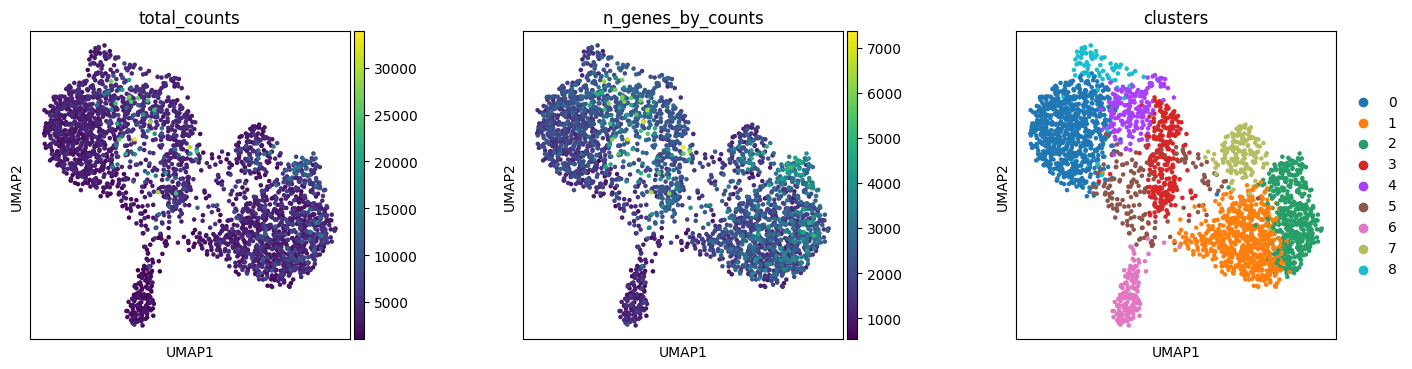

In [53]:
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.umap(adata, color=["total_counts", "n_genes_by_counts", "clusters"], wspace=0.4)

## Visualization in spatial coordinates

Let us now take a look at how total_counts and n_genes_by_counts behave in spatial coordinates. We will overlay the circular spots on top of the Hematoxylin and eosin stain (H&E) image provided, using the function sc.pl.spatial.

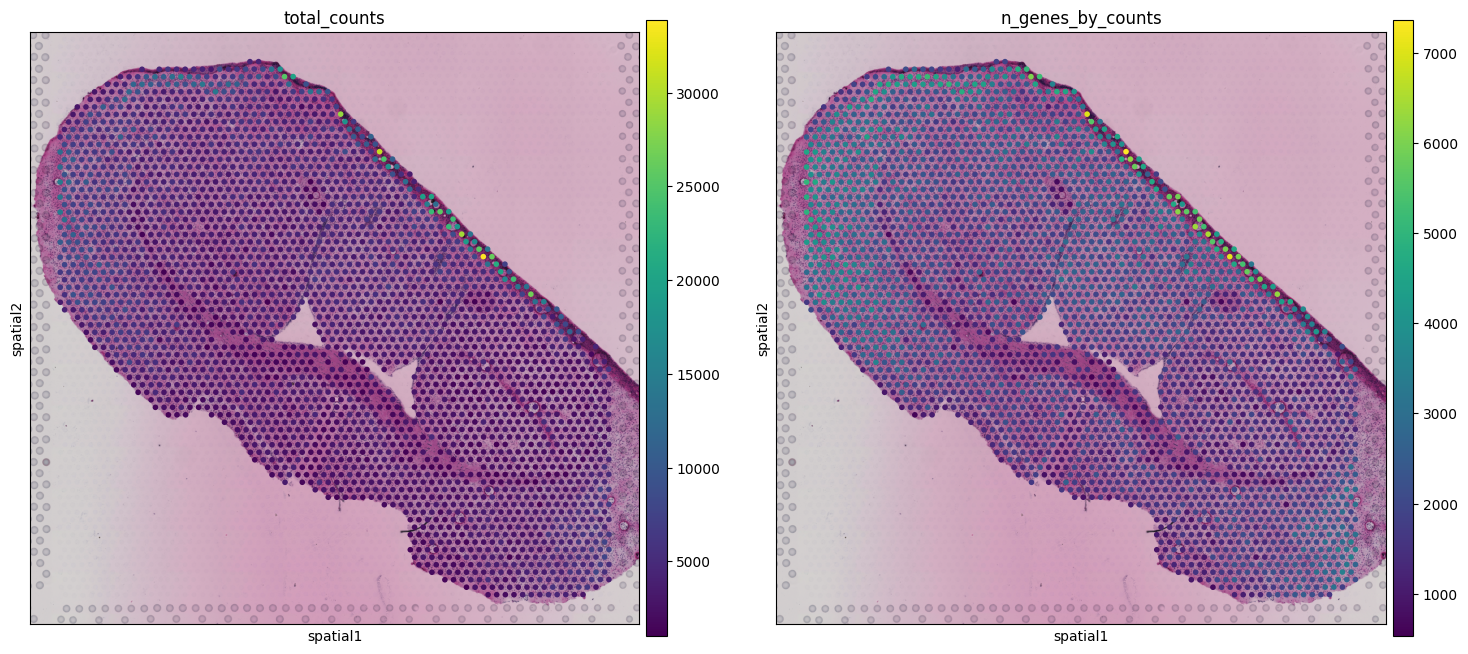

In [54]:
plt.rcParams["figure.figsize"] = (8, 8)
sc.pl.spatial(adata, img_key="hires", color=["total_counts", "n_genes_by_counts"])

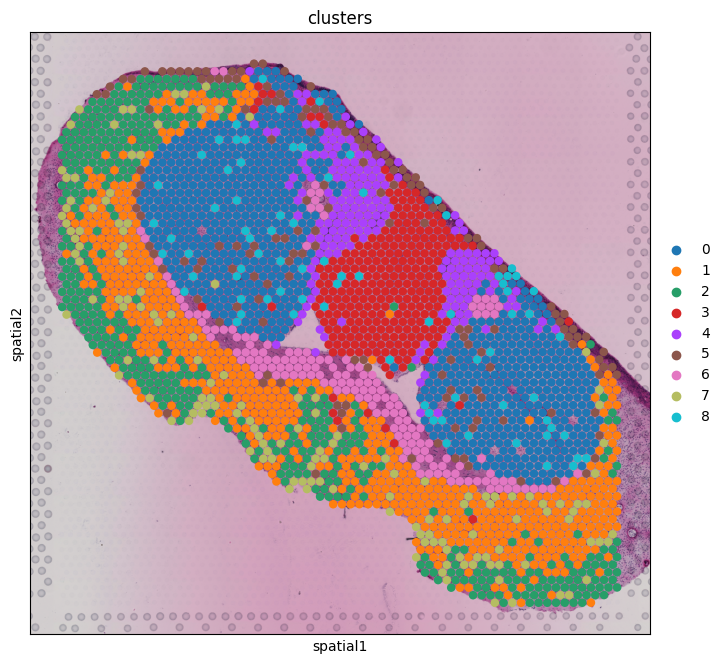

In [55]:
sc.pl.spatial(adata, img_key="hires", color="clusters", size=1.5)

In [56]:
adata

AnnData object with n_obs × n_vars = 2815 × 14501
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'clusters'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'spatial', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'clusters', 'clusters_colors'
    obsm: 'spatial', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

## Cluster marker genes
Compute marker genes and plot a heatmap with expression levels of its top 10 marker genes across clusters.

categories: 0, 1, 2, etc.
var_group_labels: 0, 1, 2


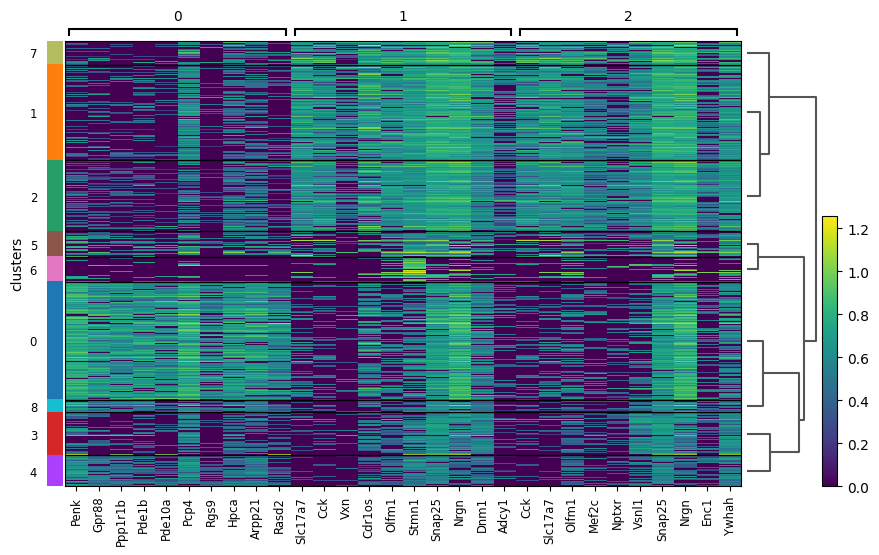

In [78]:
sc.tl.rank_genes_groups(adata, "clusters", method="t-test")
sc.pl.rank_genes_groups_heatmap(adata, groups=["0","1","2"], n_genes=10, groupby="clusters")

categories: 0, 1, 2, etc.
var_group_labels: 3, 4, 5


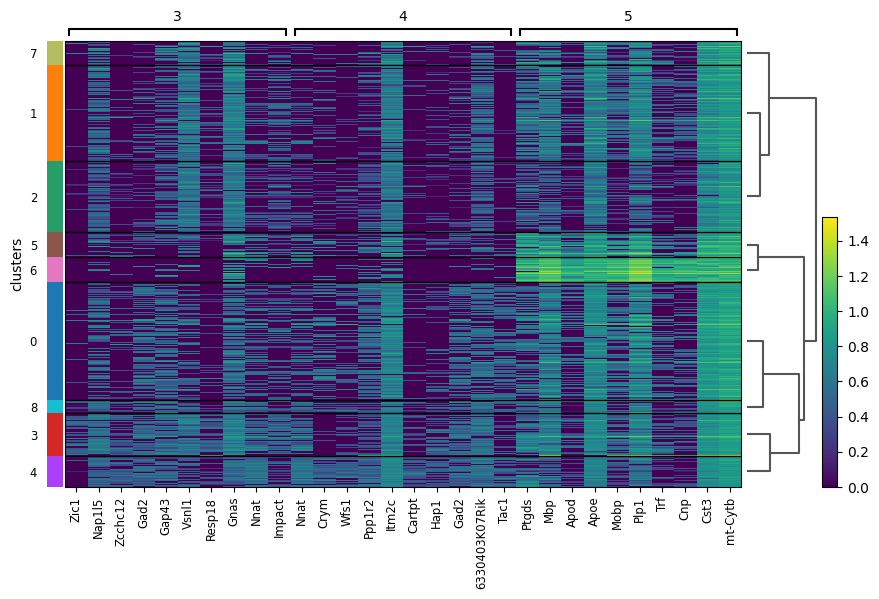

In [79]:
sc.pl.rank_genes_groups_heatmap(adata, groups=["3","4","5"], n_genes=10, groupby="clusters")

categories: 0, 1, 2, etc.
var_group_labels: 6, 7, 8


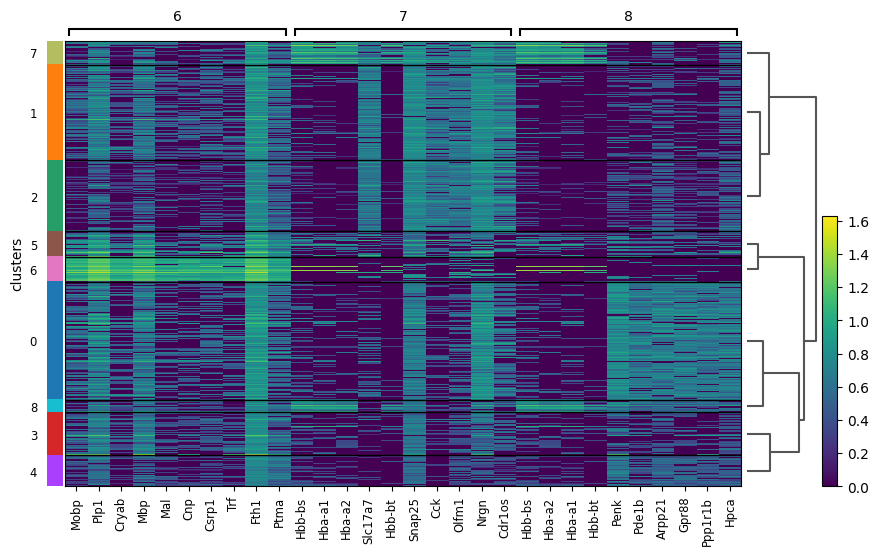

In [80]:
sc.pl.rank_genes_groups_heatmap(adata, groups=["6","7","8"], n_genes=10, groupby="clusters")

In [108]:
sc.tl.rank_genes_groups(
    adata, groupby="clusters", method="wilcoxon", key_added="dea_clusters"
)

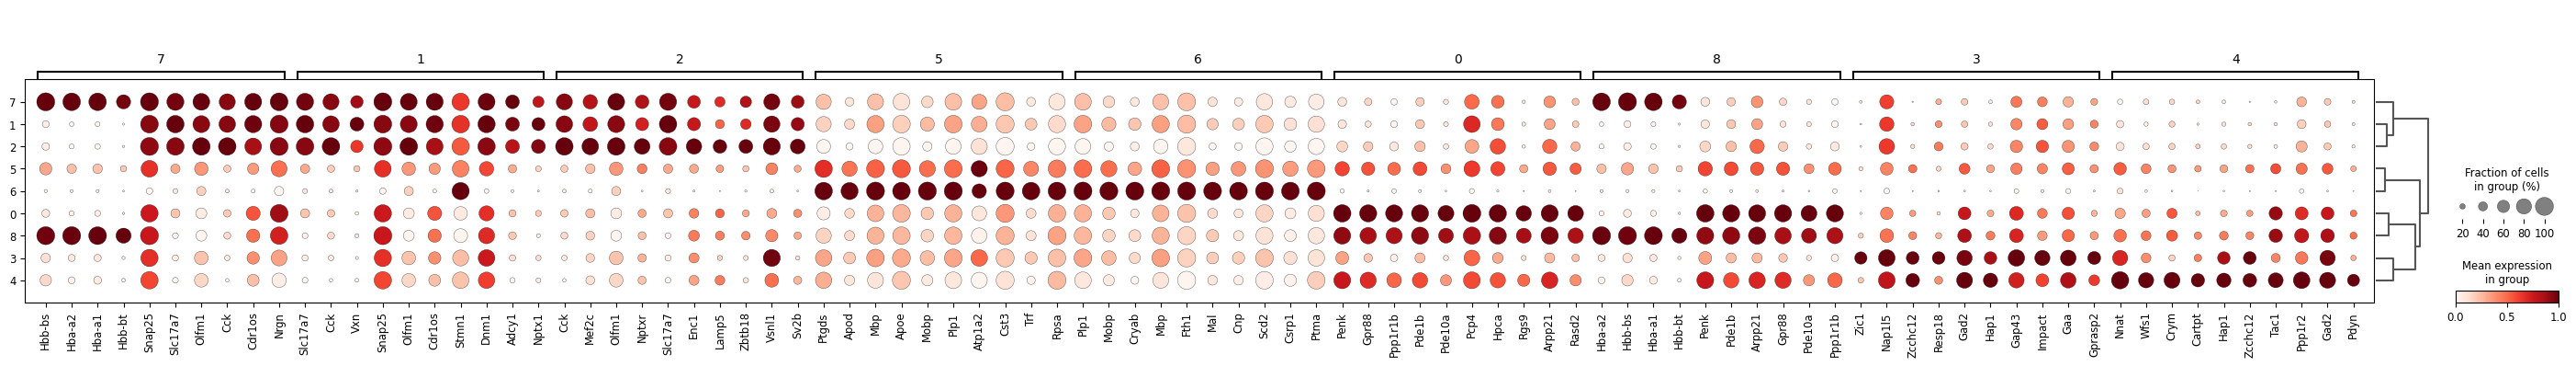

In [112]:
sc.pl.rank_genes_groups_dotplot(
    adata, groupby="clusters", standard_scale="var", n_genes=10, key="dea_clusters"
)

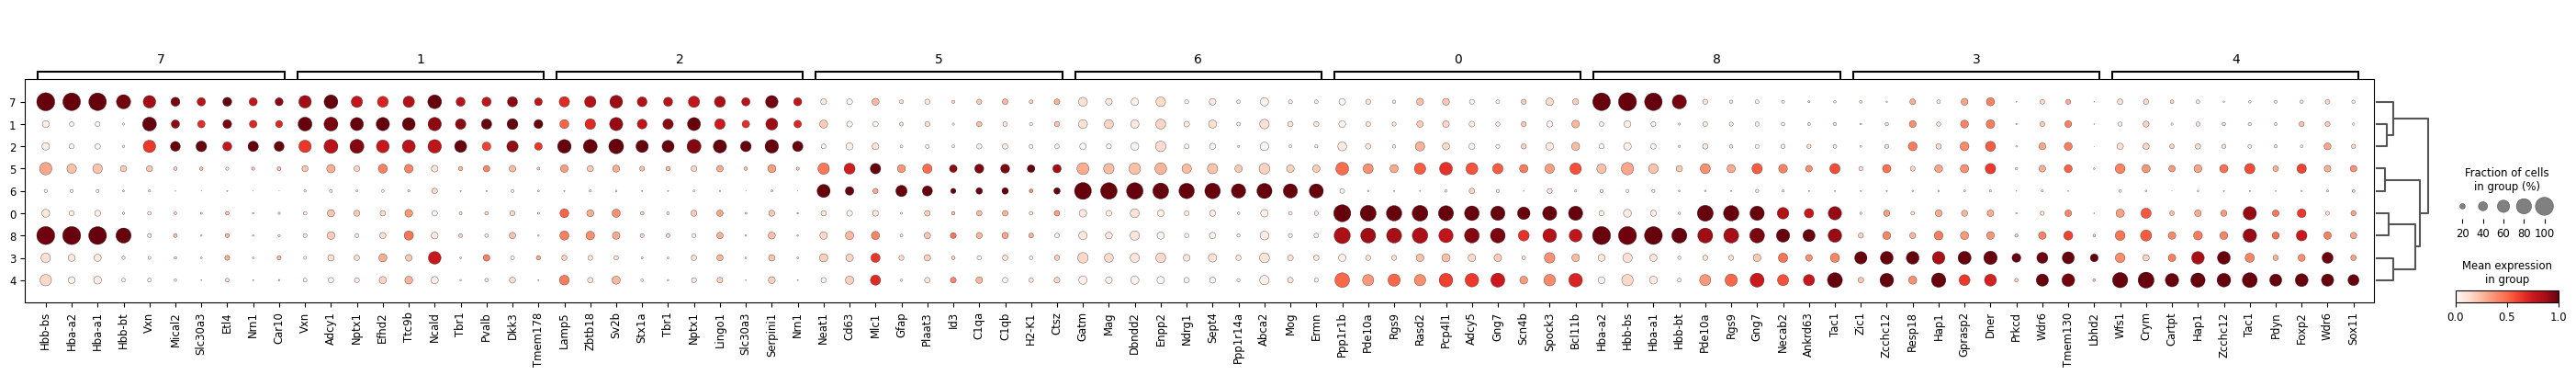

In [117]:
sc.tl.filter_rank_genes_groups(
    adata,
    min_in_group_fraction=0.3,
    max_out_group_fraction=0.4,
    key="dea_clusters",
    key_added="dea_clusters_filtered",
)
sc.pl.rank_genes_groups_dotplot(
    adata, groupby="clusters", standard_scale="var", n_genes=10, key="dea_clusters_filtered"
)

In [118]:
cluster_names = {
    "0": "Interneurons or Peptidergic Neurons",
    "1": "Neurons (Excitatory)",
    "2": "Excitatory Neurons (Cortical)",
    "3": "Inhibitory Neurons (GABAergic)",
    "4": "Astrocytes",
    "5": "Oligodendrocytes",
    "6": "Microglia (Immune cells)",
    "7": "Blood cells or Erythrocytes",
    "8": "Interneurons or Neurotransmitter-producing Neurons"
}

# Add cluster names to AnnData object
adata.obs['cluster_names'] = adata.obs['clusters'].map(cluster_names)

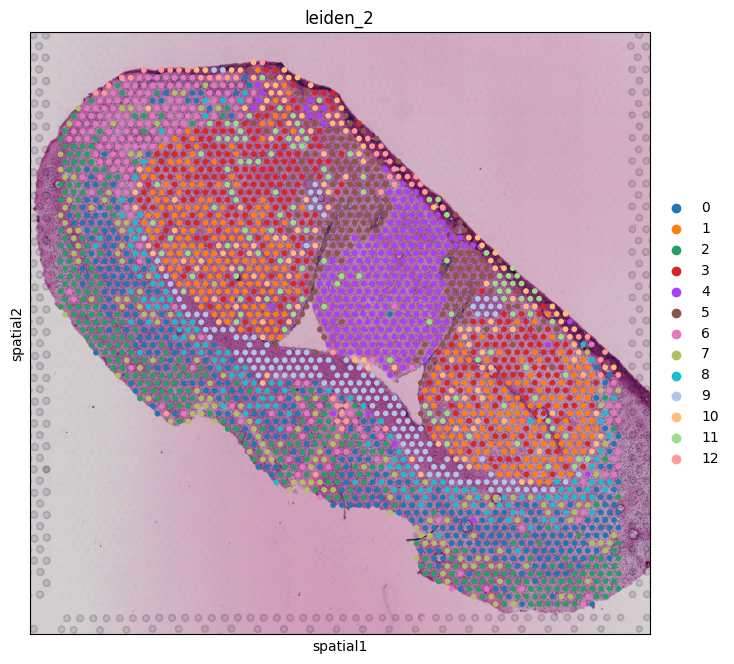

In [102]:
sc.pl.spatial(adata, img_key="hires", color=["leiden_2"])

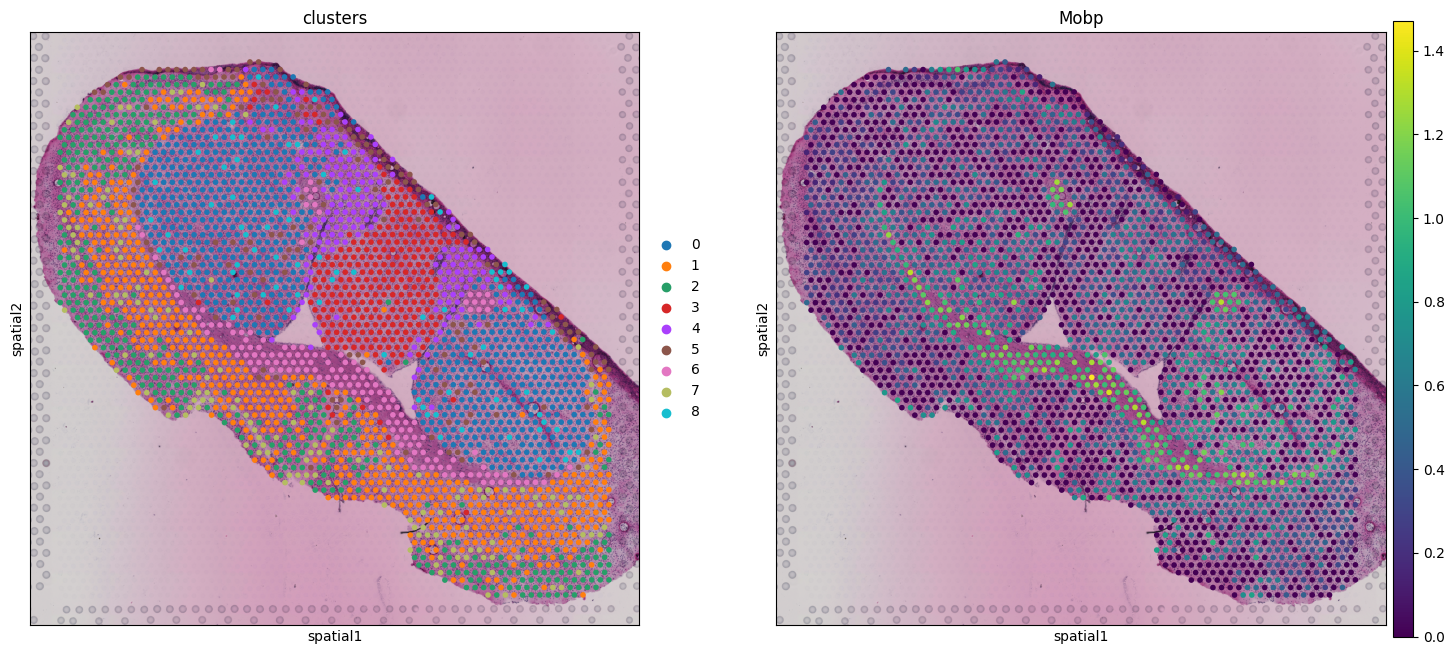

In [81]:
sc.pl.spatial(adata, img_key="hires", color=["clusters", "Mobp"])

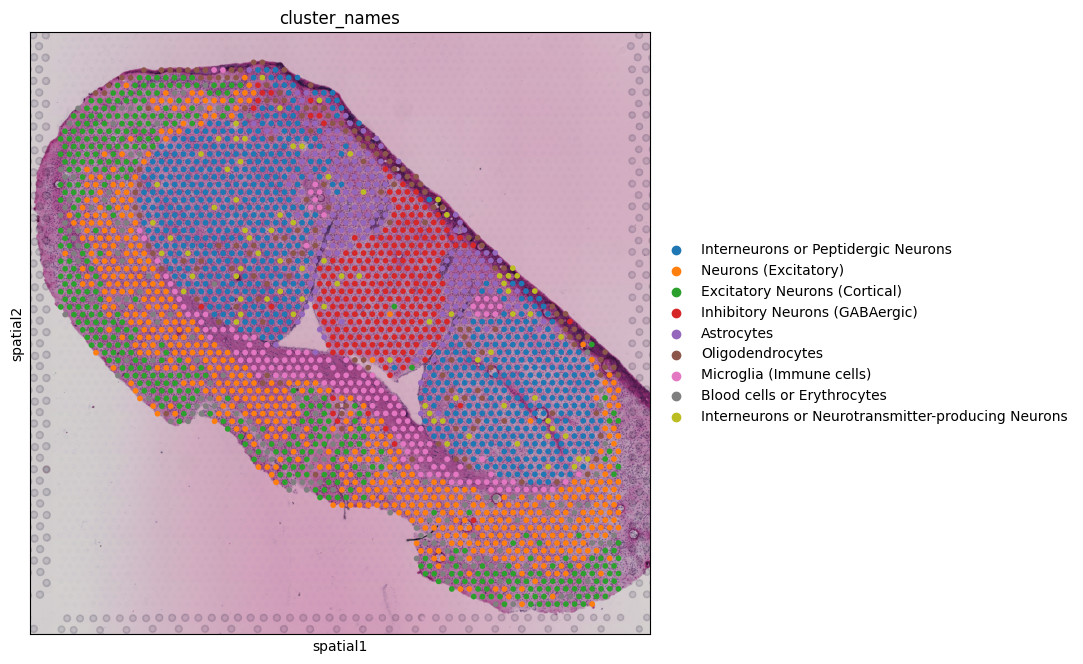

In [119]:
sc.pl.spatial(adata, img_key="hires", color=["cluster_names"])

## Extra: Spatialy variable genes 
Spatial Variation can be caused by differences in cell-type composition, overall functional dependencies or cell-cell communication events and help to understand the underlying tissue biology. Methods designed to identify spatially variable genes (SVGs) are designed to quantify whether a gene shows a significant spatial pattern by typically decomposing spatial and non-spatial variation in the dataset [Walker et al., 2022].

In [88]:
import squidpy as sq

In [89]:
sq.gr.spatial_neighbors(adata)
sq.gr.spatial_autocorr(adata, mode="moran", genes=adata.var_names)

In [90]:
adata.uns["moranI"].head()

I  pval_norm  var_norm  pval_norm_fdr_bh
Gm42418  0.673833        0.0  0.000126               0.0
Penk     0.628447        0.0  0.000126               0.0
Fth1     0.594744        0.0  0.000126               0.0
Slc17a7  0.593442        0.0  0.000126               0.0
Cck      0.581895        0.0  0.000126               0.0

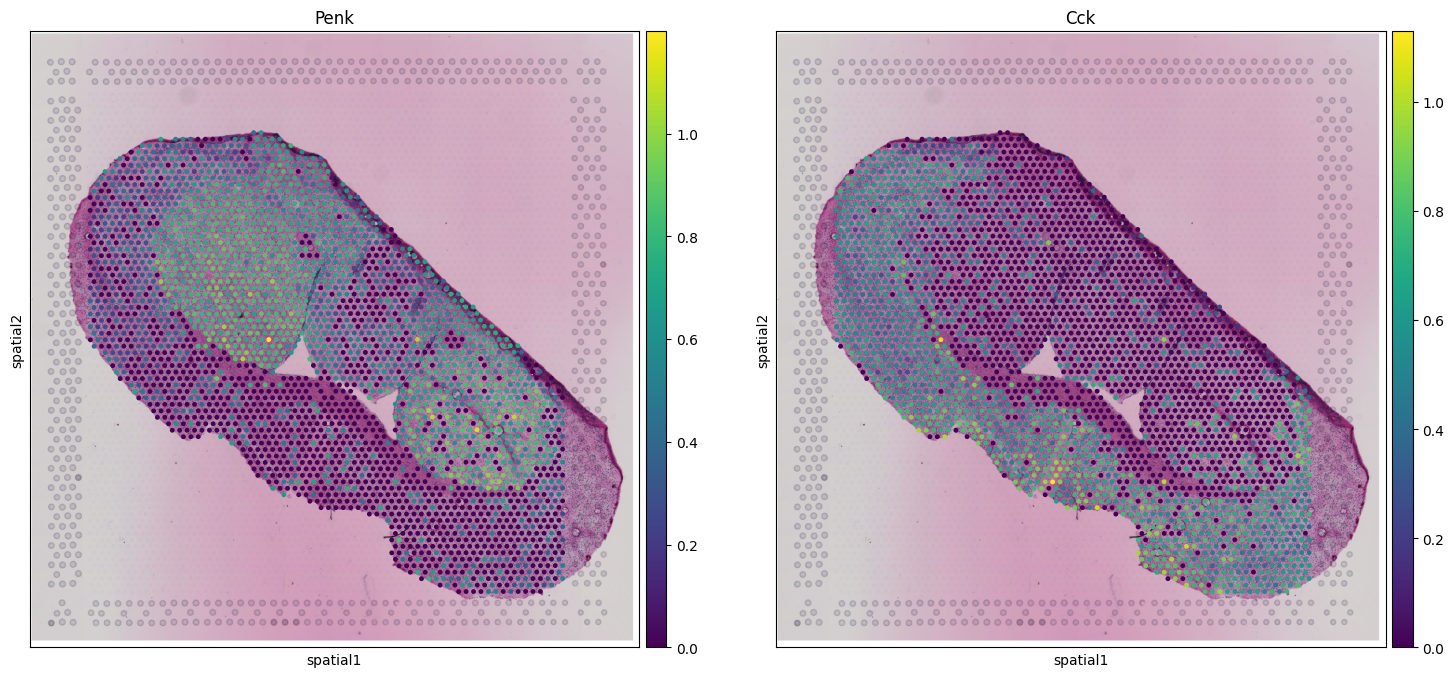

In [94]:
sq.pl.spatial_scatter(adata, color=["Penk", "Cck"])

#### We can see that the expression of both of these genes seems to show a distinct localization in the tissue. It should be noted that they might (or might not) be also marker genes for specific cell clusters. One interpretation of spatially variable genes identification is that it is an orthogonal way to perform feature selection, by selecting genes that show a variability in space (instead of, for instance, across observations, as it is usually done).

In [131]:
adata.write("V11L12-038_A1.Visium.RNA.220826_smamsi_annotated.h5ad")

In [128]:
#adata

AnnData object with n_obs × n_vars = 2815 × 14501
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'clusters', 'cluster_names', 'leiden_2'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'spatial', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'clusters', 'clusters_colors', 'rank_genes_groups', 'dendrogram_clusters', 'spatial_neighbors', 'moranI', 'leiden_2', 'leiden_2_colors', 'cluster_names_colors', 'dea_leiden_2', 'dea_clusters', 'dea_clusters_filtered'
    obsm: 'spatial', 'X_pca', 'X_umap'
    varm: 'PC

In [130]:
#del adata.uns['dea_clusters_filtered']
#have to delete this uns., if it is not allowing you to save the adata object